In [1]:
from datetime import datetime
import itertools
import json

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn import metrics
import torch
from torch.utils.data import DataLoader

from database import data_utils, data_loader, shape_utils
from models import basic_ff
import run_models

importlib.reload(data_utils)
importlib.reload(basic_ff)
importlib.reload(data_loader)
importlib.reload(shape_utils)

RUN_FOLDER = "../results/throwaway/"

In [2]:
kcm_inputs = data_utils.load_run_input_data(RUN_FOLDER, "kcm/")
atb_inputs = data_utils.load_run_input_data(RUN_FOLDER, "atb/")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [40]:
np.sum(atb_inputs['train_traces']['trip_id'].str[:3]=="ATB")

24600

In [34]:
m = atb_inputs['gtfs_data']['trip_id'].str[:3]=="ATB"
atb_inputs['gtfs_data'][m]

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id,wheelchair_accessible,stop_id,arrival_time,departure_time,...,stop_lon,stop_desc,location_type,parent_station,wheelchair_boarding,stop_timezone,vehicle_type,platform_code,arrival_s,arrival_s_prev
419310,ATB:Line:2_101,ATB:ServiceJourney:101_220805094612318_6002,ATB:DayType:635,Flatåsen via Byåsen,1,NaN,NaN,NSR:Quay:74264,25:00:00,25:00:00,...,10.391548,ved Narvesen,NaN,NSR:StopPlace:43292,NaN,NaN,3.0,NaN,90000,NaN
419738,ATB:Line:2_101,ATB:ServiceJourney:101_220805094612318_6002,ATB:DayType:635,Flatåsen via Byåsen,1,NaN,NaN,NSR:Quay:71174,25:02:00,25:02:00,...,10.393372,NaN,NaN,NSR:StopPlace:41609,NaN,NaN,3.0,NaN,90120,90000.0
422378,ATB:Line:2_101,ATB:ServiceJourney:101_220805094612318_6002,ATB:DayType:635,Flatåsen via Byåsen,1,NaN,NaN,NSR:Quay:73103,25:03:00,25:03:00,...,10.394384,i Elgsetergate ved 7-Eleven,NaN,NSR:StopPlace:42660,NaN,NaN,3.0,NaN,90180,90120.0
424425,ATB:Line:2_101,ATB:ServiceJourney:101_220805094612318_6002,ATB:DayType:635,Flatåsen via Byåsen,1,NaN,NaN,NSR:Quay:71190,25:04:00,25:04:00,...,10.390046,ved Nevrosenteret,NaN,NSR:StopPlace:41617,NaN,NaN,3.0,NaN,90240,90180.0
424882,ATB:Line:2_101,ATB:ServiceJourney:101_220805094612318_6002,ATB:DayType:635,Flatåsen via Byåsen,1,NaN,NaN,NSR:Quay:74057,25:04:00,25:04:00,...,10.386214,ved Gastrosenteret,NaN,NSR:StopPlace:43181,NaN,NaN,3.0,NaN,90240,90240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737023,ATB:Line:2_9,ATB:ServiceJourney:9_220805094610985_126,ATB:DayType:635,Lian,1,NaN,NaN,NSR:Quay:110141,26:32:00,26:32:00,...,10.343952,NaN,NaN,NSR:StopPlace:41939,NaN,NaN,0.0,NaN,95520,95460.0
737169,ATB:Line:2_9,ATB:ServiceJourney:9_220805094610985_126,ATB:DayType:635,Lian,1,NaN,NaN,NSR:Quay:73098,26:33:00,26:33:00,...,10.338053,NaN,NaN,NSR:StopPlace:42659,NaN,NaN,0.0,NaN,95580,95520.0
737315,ATB:Line:2_9,ATB:ServiceJourney:9_220805094610985_126,ATB:DayType:635,Lian,1,NaN,NaN,NSR:Quay:72109,26:34:00,26:34:00,...,10.324915,NaN,NaN,NSR:StopPlace:42124,NaN,NaN,0.0,NaN,95640,95580.0
737461,ATB:Line:2_9,ATB:ServiceJourney:9_220805094610985_126,ATB:DayType:635,Lian,1,NaN,NaN,NSR:Quay:71254,26:35:00,26:35:00,...,10.319332,NaN,NaN,NSR:StopPlace:41652,NaN,NaN,0.0,NaN,95700,95640.0


Text(0.5, 0, 'Travel Time (s)')

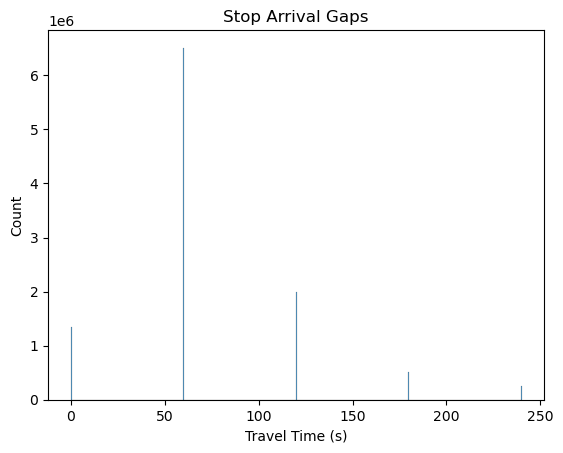

In [26]:
# Histogram of bus travel times in schedule
gtfs_data = atb_inputs['gtfs_data']
gtfs_data['arrival_s_prev'] = gtfs_data.groupby('trip_id').shift()[['arrival_s']]
gtfs_data_times = gtfs_data[['arrival_s','arrival_s_prev']].dropna()
gtfs_data_times['tt'] = gtfs_data_times['arrival_s'] - gtfs_data_times['arrival_s_prev']
# Time between bus stops
sns.histplot(gtfs_data_times.loc[gtfs_data_times['tt']<250, 'tt'])
plt.title("Stop Arrival Gaps")
plt.xlabel("Travel Time (s)")
# plt.axvline(30, 0.0, 20000, color="black")

<AxesSubplot: xlabel='dist_calc_m', ylabel='Count'>

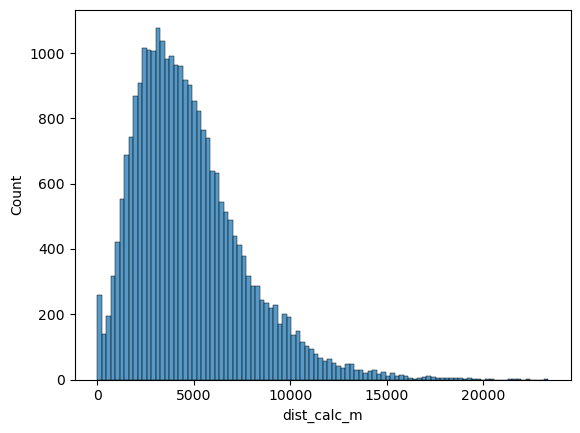

In [4]:
# Shingle distance
sns.histplot(train_traces.groupby('shingle_id').sum(numeric_only=True)['dist_calc_m'])

<AxesSubplot: xlabel='time_cumulative_s', ylabel='Count'>

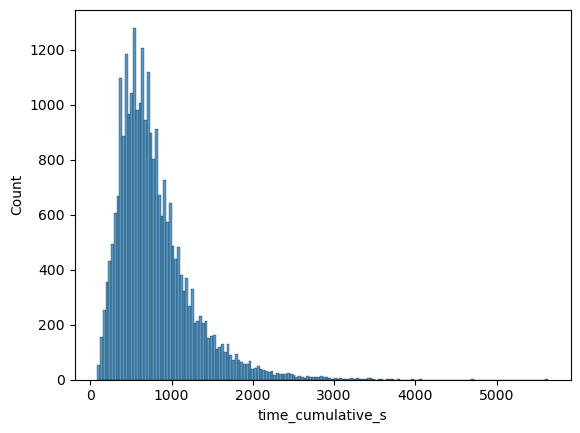

In [5]:
# Shingle travel time
sns.histplot(train_traces.groupby('shingle_id').last()['time_cumulative_s'])

<AxesSubplot: xlabel='lat', ylabel='Count'>

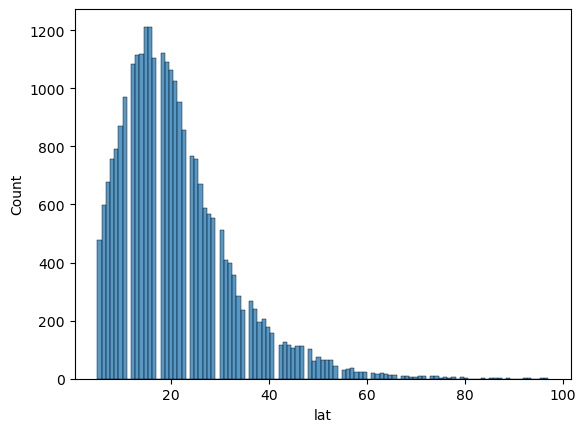

In [6]:
# Points per trajectory
sns.histplot(train_traces.groupby(['shingle_id']).count()['lat'])